In [10]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from model import simple_model_lung, vgg16_1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
#load data
with h5py.File('../dataset/h5datasets/X_train.h5', 'r') as f:
    dset = f['X_train']
    X_train = np.array(dset)

with h5py.File('../dataset/h5datasets/X_test.h5', 'r') as f:
    dset = f['X_test']
    X_test = np.array(dset)
    
with h5py.File('../dataset/h5datasets/y_train.h5', 'r') as f:
    dset = f['y_train']
    y_train = np.array(dset)
    
with h5py.File('../dataset/h5datasets/y_test.h5', 'r') as f:
    dset = f['y_test']
    y_test = np.array(dset)

In [12]:
model = simple_model_lung()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='C:\lung_sound\\result\\lung_model.ckpt', 
    save_weights_only=True, 
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 2.7182 - accuracy: 0.6548
Epoch 1: val_loss improved from inf to 20.76123, saving model to C:\lung_sound\result\lung_model.ckpt
4/4 [==============================] - 4s 776ms/step - loss: 2.7182 - accuracy: 0.6548 - val_loss: 20.7612 - val_accuracy: 0.0163
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 5.1464 - accuracy: 0.6371
Epoch 2: val_loss improved from 20.76123 to 1.04100, saving model to C:\lung_sound\result\lung_model.ckpt
4/4 [==============================] - 3s 708ms/step - loss: 5.1464 - accuracy: 0.6371 - val_loss: 1.0410 - val_accuracy: 0.8967
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.8078 - accuracy: 0.8568
Epoch 3: val_loss improved from 1.04100 to 0.55708, saving model to C:\lung_sound\result\lung_model.ckpt
4/4 [==============================] - 3s 735ms/step - loss: 1.8078 - accuracy: 0.8568 - val_loss: 0.5571 - val_accuracy: 0.8967
Epoch 4/100
4/4 [===

In [16]:
model.load_weights('../result/lung_model.ckpt')

Accuracy: 95%
Loss: 0.1219



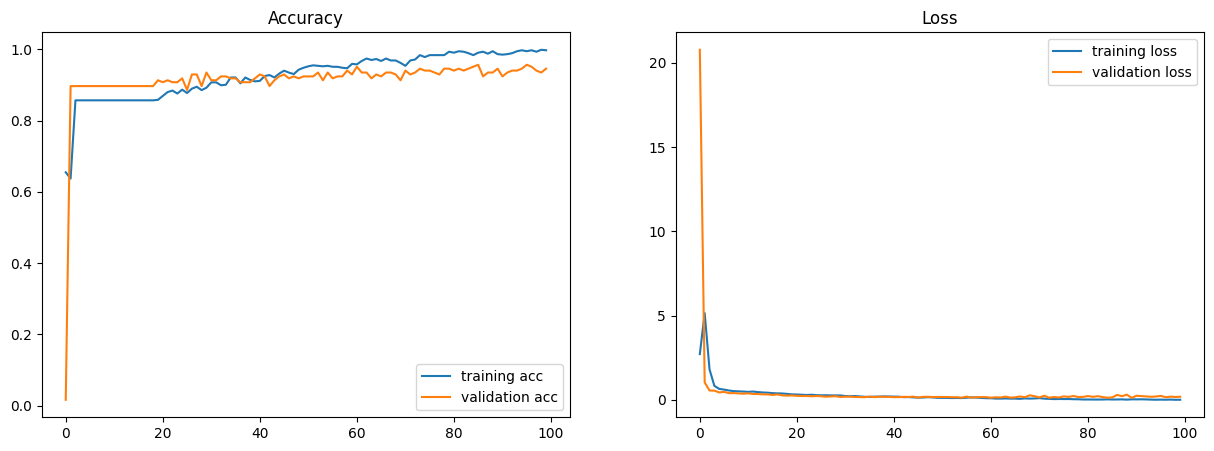

In [17]:
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

6/6 [==============================] - 0s 21ms/step
                precision    recall  f1-score   support

          COPD       0.99      0.99      0.99       165
       Healthy       0.60      0.43      0.50         7
          URTI       0.33      0.50      0.40         4
Bronchiectasis       1.00      1.00      1.00         4
     Pneumonia       0.50      0.67      0.57         3
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.95       184
     macro avg       0.57      0.60      0.58       184
  weighted avg       0.95      0.95      0.94       184



c:\Users\mte20\anaconda3\envs\DS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mte20\anaconda3\envs\DS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mte20\anaconda3\envs\DS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: xlabel='Predicted', ylabel='Actual'>

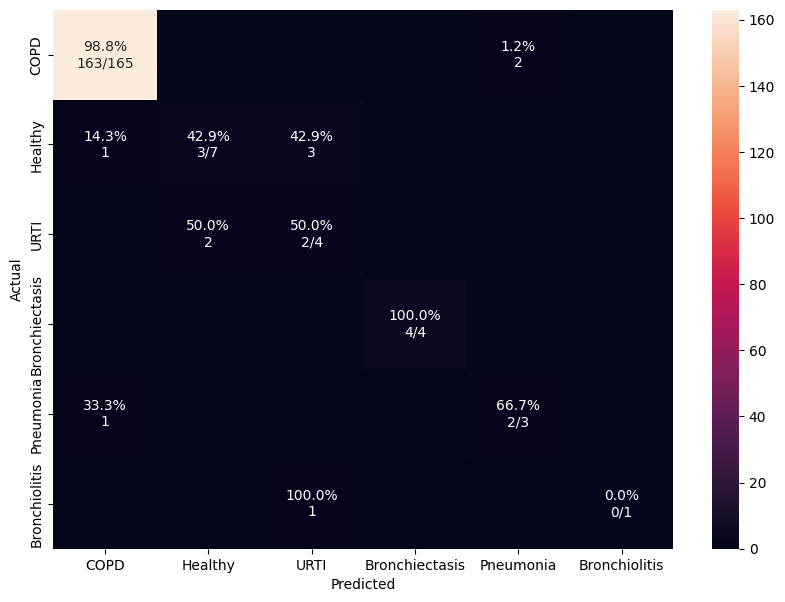

In [18]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumonia", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)

df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')